In [25]:
import sys

In [27]:
sys.path.append("D:/Downloads/Documents/VNPOST/OCR/Mail_ocr_2/VnPost/Hai/utils")

In [28]:
import matplotlib.pyplot as plt
import cv2
import onnxruntime as ort
from VnPost.Hai.utils.onnx_infer_obb import OCR_pipeline
import numpy as np
import shapely
from pathlib import Path
from ultralytics import YOLO
from utility import get_best_obb, obb_letterbox_to_origin

In [9]:
def anyobb_to_tltrblbr(obb: np.ndarray):
    """
    Convert any order of 4 points of an oriented bounding box (OBB) to
    top-left, top-right, bottom-left, bottom-right order.

    Behavior
    --------
    - Find the center of the OBB
    - Determine the quadrant of each point relative to the center
    - Sort points based on their quadrant to achieve the desired order


    Parameters
    ----------
    - obb : `np.ndarray`
        - Array of shape (4, 2) representing the 4 corner points of the OBB.
        - The values are in x, y percentage relative to the image size.

    Returns
    -------
    - tltrblbr : `np.ndarray`
        - Array of shape (4, 2) representing the 4 corner points of the OBB in
        top-left, top-right, bottom-left, bottom-right order.
        - The values are in x, y percentage relative to the image size.
    """

    center = obb.mean(axis=0)
    pos_bool = obb > center
    pos_rank = pos_bool[:, 0] * 2 + pos_bool[:, 1]
    pos_ordered = np.argsort(pos_rank)
    tltrblbr = obb[pos_ordered]
    return tltrblbr


In [10]:
yolo_obb = YOLO("weights/Onnx/Yolo/obb/yolo_obb_nms.onnx")

yolo_obb_onnx = ort.InferenceSession(
    "weights/Onnx/Yolo/obb/yolo_obb_nms.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)
paddle_cls_onnx = ort.InferenceSession(
    "weights/Onnx/OCR/doc_cls/doc_cls.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)
paddle_det_onnx = ort.InferenceSession(
    "weights/Onnx/OCR/det/det.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)

vietocr_cnn = ort.InferenceSession(
    "weights/Onnx/OCR/rec/cnn.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)
vietocr_cnn_encoder = ort.InferenceSession(
    "weights/Onnx/OCR/rec/encoder.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)
vietocr_cnn_decoder = ort.InferenceSession(
    "weights/Onnx/OCR/rec/decoder.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)

OCR = OCR_pipeline(
    yolo_obb_onnx,
    paddle_cls_onnx,
    paddle_det_onnx,
    vietocr_cnn,
    vietocr_cnn_encoder,
    vietocr_cnn_decoder,
)


In [15]:
img_path = "D:/Downloads/Documents/VNPOST/stuf/images_raw_rename/3064.jpg"

In [16]:
image = cv2.imread(img_path)

result, sentences = OCR.ocr(image)

In [32]:
ppc, scale, padx, pady = OCR._preprocess_yolo_obb(image)
onnx_pred = yolo_obb_onnx.run(None, {"images": ppc})[0].squeeze()
best_box = get_best_obb(onnx_pred)
final_box = obb_letterbox_to_origin(best_box, padx, pady, scale)


In [23]:
real_4xy = np.array(
    list(
        map(
            float,
            (
                Path("D:/Downloads/Documents/VNPOST/stuf/test_data/addr_bbox/")
                / Path(img_path).with_suffix(".txt").name
            )
            .read_text()
            .strip()
            .split(" ")[1:],
        )
    )
).reshape(4, 2)

In [34]:
real_4xy * np.array(image.shape[1::-1])


array([[     3296.9,      1588.1],
       [       1841,        1559],
       [     1857.6,      729.74],
       [     3313.5,      758.86]])

In [36]:
final_box

array([[     3338.5,      1648.1],
       [     3357.7,      743.89],
       [     1839.3,      711.69],
       [     1820.1,      1615.9]], dtype=float32)

In [38]:
poly_pred = shapely.geometry.Polygon(final_box)
poly_real = shapely.geometry.Polygon(real_4xy * np.array(image.shape[1::-1]))
poly_pred.intersection(poly_real).area / poly_pred.union(poly_real).area

0.8793608456670148

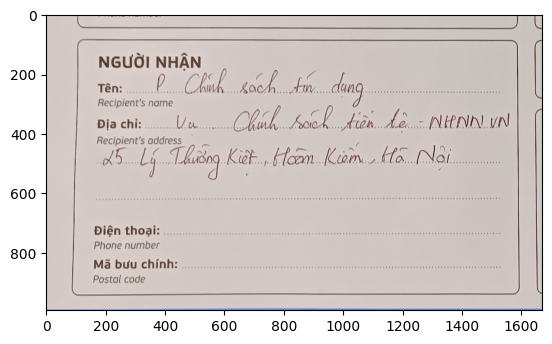

In [35]:
plt.imshow(result)